In [1]:
import pandas as pd
import pylab as plt
import seaborn as sns
%pylab inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Machine Learning in Python
**Objective:** Implement key steps in a supervised learning work-flow with SciKitLearn.

**Methods to cover:** Feature engineering (dummy variables), train-test split, fitting decision trees, adjust hyper-parameters, grid-search and cross-validation, confusion matrix, ROC curve.

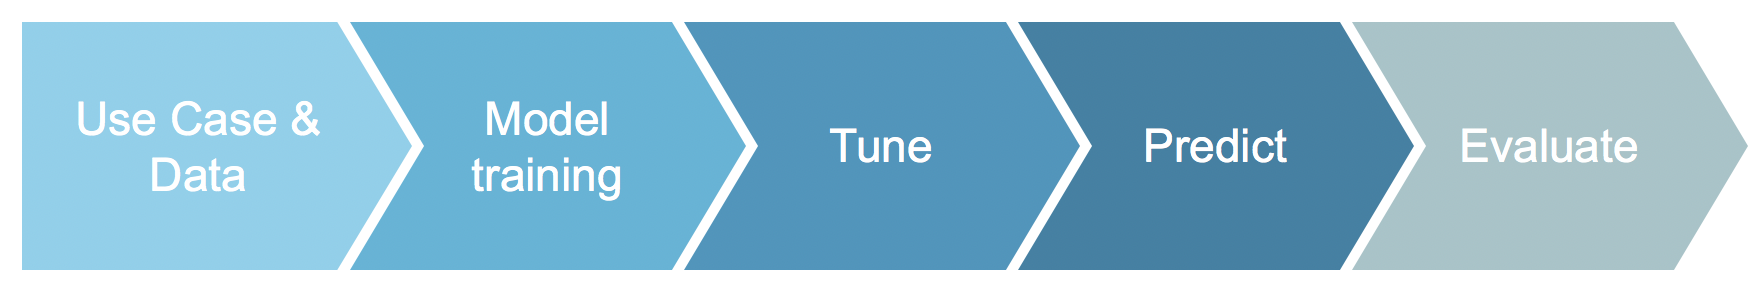

In [37]:
Image('https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%208/data/5_steps.png', width = 600)

## Worked Example 1: Predicting mode of travel to work

For a workshop in November 2018, participants filled out a survey (56 responses) based on the following fictional scenario:

**A new cohort of 100 staff have just been hired, and will start after Thanksgiving. We need to decide how many bike racks or parking spaces to build for them. To do so, we'll use data on current staff to build a machine learning model. For fun, we'll also predict whether staff prefer classical music or heavy metal.**

The data was collected on Google Forms and downloaded as a CSV.

#### 1. Load and inspect the data

In [4]:
url = 'https://raw.githubusercontent.com/worldbank/Python-for-Data-Science/master/Spring%202019%208-week%20course/week%208/data/responses2.csv'

df = pd.read_csv(url, skiprows = 1, names = ['gender','household_type','state','favorite_food','exercise_regime','mode_of_travel','arrival_time','music_choice','purchase_history','age'])
df = df[['gender','household_type','state','favorite_food','exercise_regime','purchase_history','age','music_choice','arrival_time','mode_of_travel']]

df.head()

gender                        household_type state favorite_food  \
0    Male                I live with my family.    DC         Steak   
1  Female  I live by myself or with housemates.    DC       Mexican   
2    Male  I live by myself or with housemates.    DC  Home cooking   
3    Male                I live with my family.    DC  Home cooking   
4  Female  I live by myself or with housemates.    DC  Home cooking   

                      exercise_regime  \
0  Keep fit through yoga and jogging.   
1    Keep fit through jogging or gym.   
2    Keep fit through jogging or gym.   
3    Keep fit through jogging or gym.   
4    Keep fit through jogging or gym.   

                                    purchase_history    age  \
0                                                NaN    NaN   
1                                    Theater tickets  35-44   
2                                    Theater tickets  25-34   
3  Gardening or home improvement gear, Bluetooth ...  35-44   
4  Gardening or home improvement gear, Bluetooth ...  25-34   

         music_choice arrival_time mode_of_travel  
0  Heavy metal / rock   9:00:00 AM   Walk or bike  
1     Classical music   7:30:00 AM   Walk or bike  
2     Classical music   9:30:00 AM          Train  
3     Classical music   9:00:00 AM   Walk or bike  
4     Classical music   8:30:00 AM   Walk or bike

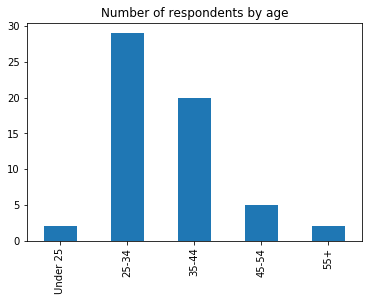

In [5]:
# Our respondents are from a broad set of ages

pd.Series(df.age.value_counts(sort=False),
          index=['Under 25','25-34','35-44','45-54','55+']).plot(kind='bar',title='Number of respondents by age');

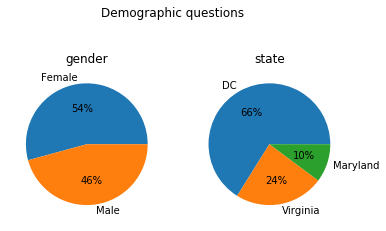

In [6]:
# Slightly more women than men. The majority live in DC.

fig,axes = plt.subplots(nrows=1,ncols=2)
pies = ['gender','state']

for n,i in enumerate(pies):
    ax = axes.flatten()[n]
    df[i].value_counts().plot(kind='pie',autopct='%1.0f%%',ax=ax)
    ax.set(ylabel='',title=i)

fig.suptitle("Demographic questions");

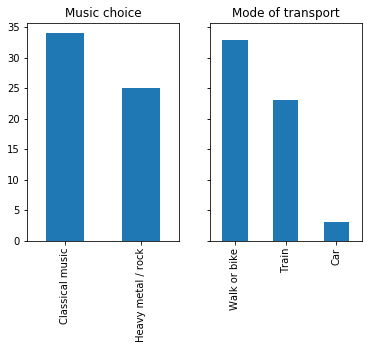

In [7]:
# Inspect the target variables (music choice, mode of transport).
fig,axes = plt.subplots(1,2,sharey=True)
df.mode_of_travel.value_counts().plot(kind='bar',ax=axes[1],title='Mode of transport')
df.music_choice.value_counts().plot(kind='bar',ax=axes[0],title='Music choice');

#### 3. Create a machine-readable set of features
* We have one main continuous variable: age
* And many categorical variables (eg State = DC, Maryland or Virginia).

In [8]:
# For age, replace the current strings (eg. '23-34') with the midpoint.
df['age'] = df.age.map({'Under 25':20,'25-34':29.5,'35-44':39.5,'45-54':49.5,'55+':60})

In [9]:
# To make a categorical variable like State machine-readable, use one-hot encoding
pd.get_dummies(df.state[:10])

DC  Maryland  Virginia
0   1         0         0
1   1         0         0
2   1         0         0
3   1         0         0
4   1         0         0
5   1         0         0
6   0         0         1
7   1         0         0
8   0         1         0
9   1         0         0

In [10]:
# Transform gender, household_type, state, food and exercise to dummies

for feature in ['gender','household_type','state','favorite_food','exercise_regime']:
    dummy_feature = pd.get_dummies(df[feature])
    df = pd.concat([df,dummy_feature], axis=1)

In [11]:
# Transform the purchases data from string (eg. 'yoga mat, theater tickets') to a list.  

df.purchase_history = df.purchase_history.astype(str)
df.purchase_history = [cell.split(',') for cell in df.purchase_history]

# Create dummies for purchase history

items = ['Theater tickets','Yoga mat','Bluetooth speaker / headphones',
             'Gardening or home improvement gear',' Presents for my kids']

for item in items:
    df[item] = [item in cell for cell in df.purchase_history]
    df[item] = df[item].map({False:0,True:1})

In [12]:
# Our target variables are currently strings
df.mode_of_travel[:5]

0    Walk or bike
1    Walk or bike
2           Train
3    Walk or bike
4    Walk or bike
Name: mode_of_travel, dtype: object

In [13]:
# Map the TRANSPORT and MUSIC_CHOICE columns (our target variables) to 0s/1s

y_transport = df.mode_of_travel.map({'Train':0,'Car':0,'Walk or bike':1})
y_music = df.music_choice.map({'Classical music':0,'Heavy metal / rock':1})


In [14]:
# Fill gaps in the age column with the mean

df.age.fillna(value = df.age.mean(), inplace = True)

In [15]:
# Predictive features are typically denoted X
# Target variable is typically denoted y

# y = f(X) where X is a matrix comprising features x1 to xn.

features_to_use = ['Theater tickets', 'Yoga mat', 'Bluetooth speaker / headphones', 'Gardening or home improvement gear',
       ' Presents for my kids', 'age', 'Female', 'Male',
       'I live by myself or with housemates.', 'I live with my family.', 'DC',
       'Maryland', 'Virginia', 'Home cooking', 'Mexican', 'Steak', 'Sushi',
       'Vegetarian', 'I play team sports / run races.',
       'Keep fit through jogging or gym.','Netflix is my most strenuous exercise.']

X = df[features_to_use]



In [16]:
X.head(2) # Processed set of features:

Theater tickets  Yoga mat  Bluetooth speaker / headphones  \
0                0         0                               0   
1                1         0                               0   

   Gardening or home improvement gear   Presents for my kids        age  \
0                                   0                      0  35.396552   
1                                   0                      0  39.500000   

   Female  Male  I live by myself or with housemates.  I live with my family.  \
0       0     1                                     0                       1   
1       1     0                                     1                       0   

   ...  Maryland  Virginia  Home cooking  Mexican  Steak  Sushi  Vegetarian  \
0  ...         0         0             0        0      1      0           0   
1  ...         0         0             0        1      0      0           0   

   I play team sports / run races.  Keep fit through jogging or gym.  \
0                                0                                 0   
1                                0                                 1   

   Netflix is my most strenuous exercise.  
0                                       0  
1                                       0  

[2 rows x 21 columns]

#### 4. Build decision tree model
**4.1 TRANSPORT**

In [17]:
# For our training and test sets, we could just take the first 70% and the last 30% of rows respectively
n_rows = len(df)
index_70_percent = int(n_rows * 0.7)

In [18]:
X_train = X[:index_70_percent]
X_test = X[index_70_percent:]
y_train = y_transport[:index_70_percent]
y_test = y_transport[index_70_percent:]

In [19]:
# the train_test_split function does it for us, with randomization.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y_transport,test_size=0.3)

In [20]:
# check the dataframes are the right size

print("TRAINING SET")
print("X_train (features for the model to learn from): {} rows, {} columns".format(X_train.shape[0], X_train.shape[1]))
print("y_train (labels for the model to learn from): {} rows\n".format(y_train.shape[0]))
print("TEST SET")
print("X_test (features to test the model's accuracy against): {} rows, {} columns".format(X_test.shape[0], X_test.shape[1]))
print("y_test (labels to test the model's accuracy with): {} rows".format(y_test.shape[0]))


TRAINING SET
X_train (features for the model to learn from): 41 rows, 21 columns
y_train (labels for the model to learn from): 41 rows

TEST SET
X_test (features to test the model's accuracy against): 18 rows, 21 columns
y_test (labels to test the model's accuracy with): 18 rows


In [21]:
# Instantiate a classifier:

tree = DecisionTreeClassifier(max_depth=3,min_samples_leaf=3)

In [22]:
# Fit it with the training data:

tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [23]:
# to visualize, paste output file into www.webgraphviz.com

#export_graphviz(tree_transport, out_file='tree.dot', 
#                feature_names = X,
#                class_names = ['Train/car','walk/bike'],
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

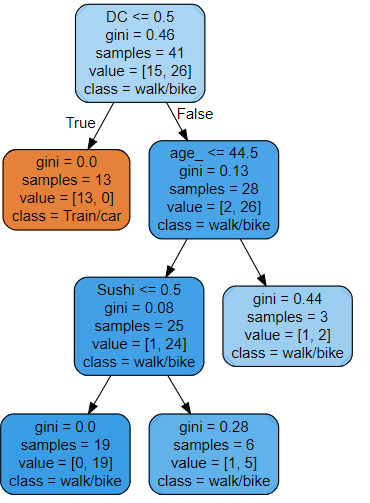

In [35]:
from IPython.display import Image
Image('https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%208/data/tree1.png')

**4.2 MUSIC TASTE**

In [25]:
X_train_music, X_test_music, y_train_music, y_test_music = train_test_split(X,y_music,test_size=0.3)

In [26]:
tree_music = DecisionTreeClassifier(max_depth=3)
tree_music.fit(X_train_music,y_train_music)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [27]:
#export_graphviz(music_tree, out_file='tree2.dot', 
#                feature_names = X,
#                class_names = ['Classical','Metal'],
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

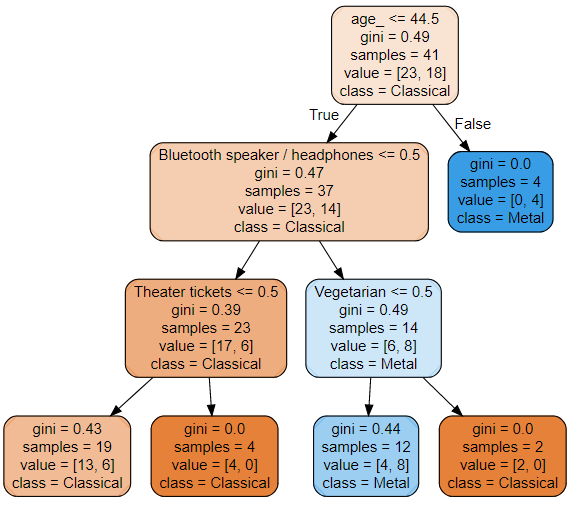

In [36]:
Image('https://github.com/worldbank/Python-for-Data-Science/raw/master/Spring%202019%208-week%20course/week%208/data/tree2.png')

#### 4. Predict against test set, evaluate performance

In [29]:
predictions_transport = tree.predict(X_test)

print("TRANSPORT: First 10 predictions: {}".format(predictions_transport[:10].tolist()))

TRANSPORT: First 10 predictions: [1, 0, 1, 1, 1, 1, 1, 0, 1, 1]


In [30]:
# How many of the predicted value equal the actual values?
n_samples = len(predictions_transport)
n_correct = sum(predictions_transport == y_test)
accuracy = n_correct / n_samples * 100

print("TRANSPORT - We predicted {} right out of {} examples. That's a {:.1f} % accuracy rate.".format(
    n_correct,n_samples,accuracy))

TRANSPORT - We predicted 14 right out of 18 examples. That's a 77.8 % accuracy rate.


In [31]:
# Check accuracy for music

predictions_music = tree_music.predict(X_test_music)

print("MUSIC - We predicted {} right out of {} examples. That's a {:.1f} % accuracy rate.".format(
    sum(predictions_music == y_test_music),n_samples,sum(predictions_music == y_test_music)/n_samples*100))

MUSIC - We predicted 9 right out of 18 examples. That's a 50.0 % accuracy rate.


--> Note that the transport model addresses an easy task, whereas predicting musical taste seems difficult. What could boost the prediction accuracy? Two approaches: get more data to train your models on, or improve the model.

## Worked Example 2: Predict building earthquake damage from Nepal

This is a currently on-going challenge hosted by DrivenData (https://www.drivendata.org/competitions/57/nepal-earthquake/data/). For the source data, register and download it.

**Based on aspects of building location and construction, your goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.**

The data was collected through surveys by the Central Bureau of Statistics that work under the National Planning Commission Secretariat of Nepal. This survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

Prediction variable: `damage_grade`:
* 1 represents low damage
* 2 represents a medium amount of damage
* 3 represents almost complete destruction

Selected features:
* `count_floors_pre_eq`: number of floors before the earthquake
* `age`: age of the building in years
* `area`: normalized area of the building footprint
* `foundation type`: the type of foundation used when building
* `has_superstructure_bamboo`: flag variable indicating the superstructure was made of bamboo
* `has_superstructure_rc_engineered`: flag variable indicating the superstructure was made of reinforced concrete

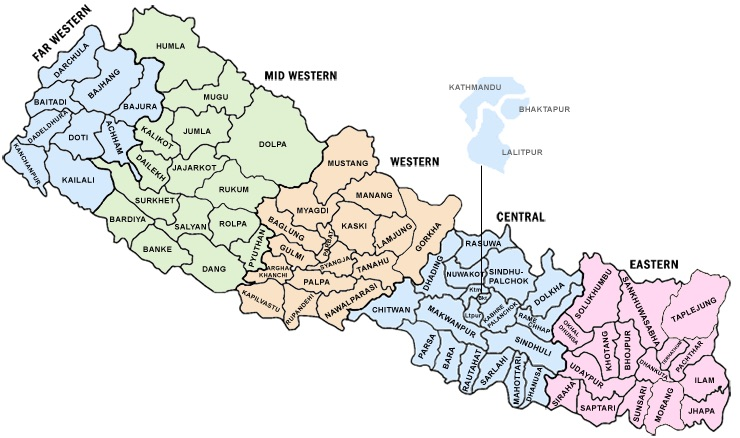

In [32]:
Image('http://localnepaltoday.com/wp-content/uploads/2015/08/image9.jpg')

#### 1. Import data, create training and test sets

In [38]:
X = pd.read_csv('https://github.com/worldbank/Python-for-Data-Science/raw/master/July_2019_Poverty_GP/day_3/test_values.csv')
y = pd.read_csv('https://github.com/worldbank/Python-for-Data-Science/raw/master/July_2019_Poverty_GP/day_3/train_labels.csv', usecols = ['damage_grade'])

In [ ]:
print("Dataset has {} rows and {} columns.".format(*X.shape))
X.head(2)

In [ ]:
columns_to_make_dummies_from = ['land_surface_condition',
'foundation_type',
'roof_type',
'ground_floor_type',
'other_floor_type',
'position',
'plan_configuration',
'legal_ownership_status']

In [ ]:
for column in columns_to_make_dummies_from:
        X.append(pd.get_dummies(X[column]))

X = X.drop(columns = columns_to_make_dummies_from)
X = X.drop(columns = 'building_id')

In [ ]:
# For now, let's group together 'low' and 'medium' damage categories, making this a binary classification problem.

y = pd.Series(y.damage_grade.map({3:1, 2:0, 1:0}))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## LAB SESSION:

**1. Conduct exploratory visualization** of the earthquake damage data.

You may want to answer questions like: (i) what's the distribution of building age, height and floorspace; (ii) are the two classes of our outcome variable evenly balanced; (iii) was severe damage more frequent for some categories of buildings?

Use Pandas plotting functions such as `df.plot(kind = 'bar, barh, pie')` or `df.hist()`.


**2. Split the data into training and test sets.**

You should feed in `X` and `y` and return four outputs.


**3. Fit a decision tree** (call it `tree`). Then **fit a random forest** with 10 trees (call it `rf`).

This requires RandomForestClassifier, specifying the parameter n_estimators for number of trees. Explore the other hyper-parameters available.

If fitting the full dataset takes too long, use a subset of the data (eg. 1000 rows).
    
    
**4. Predict against the test set** and see what percent of the predictions were correct.

Try manually adjusting your `rf`'s hyper-parameters (eg. number of trees, depth of trees). See how performance changes.

#### 2. Train model

In [38]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [39]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### 3. Predict against test set, evaluate performance

In [40]:
predictions_tree = tree.predict(X_test)
sum(predictions_tree == y_test) / len(y_test) *100

# or use the built in .score() method

74.33193657810318

In [41]:
rf.score(X_test, y_test)

0.7733419287501343

#### 4. Model tuning
Three ways to make your model better:
* More data
* Better model
* Better data

In [42]:
nrows = np.linspace(1000, 200000, 10)
nrows

array([  1000.        ,  23111.11111111,  45222.22222222,  67333.33333333,
        89444.44444444, 111555.55555556, 133666.66666667, 155777.77777778,
       177888.88888889, 200000.        ])

Text(0.5, 1.0, 'Accuracy versus number of rows')

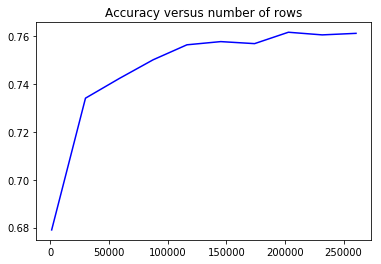

In [43]:
# Accuracy versus amount of training data
n_rows = np.linspace(1000, X.shape[0], 10).astype(int)
accuracy_list = []

for n in n_rows:
    rf = RandomForestClassifier(n_estimators = 5)
    rf.fit(X_train[:n],y_train[:n])
    preds = rf.predict(X_test)
    accuracy = sum(preds == y_test) / len(y_test)
    accuracy_list.append(accuracy)
    
f, ax = plt.subplots()
sns.lineplot(x = n_rows, y = accuracy_list, color = 'b', ax = ax)
plt.title('Accuracy versus number of rows')

Text(0.5, 1.0, 'Accuracy versus number of trees')

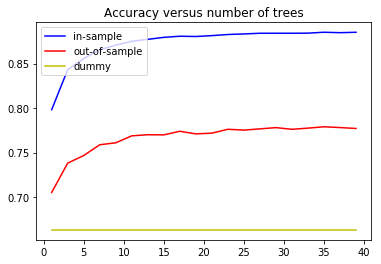

In [44]:
# Accuracy versus number of trees

def evaluate_accuracy(model):
    ''' Returns in-sample accuracy, out-of-sample accuracy'''
    return(model.score(X_train, y_train),
          model.score(X_test, y_test))

IS_accuracy_list = []
OS_accuracy_list = []
OS_dummy_accuracy_list = []
n_estimators = np.arange(1, 40, 2)
nrows = 100000

for i in n_estimators:
    rf = RandomForestClassifier(n_estimators = i)
    dc = DummyClassifier(strategy = 'most_frequent')
    rf.fit(X_train[:nrows],y_train[:nrows])
    dc.fit(X_train[:nrows],y_train[:nrows])
    IS_accuracy, OS_accuracy = evaluate_accuracy(rf)
    IS_accuracy_list.append(IS_accuracy)
    OS_accuracy_list.append(OS_accuracy)
    OS_dummy_accuracy_list.append(evaluate_accuracy(dc)[1])
    
f, ax = plt.subplots()
sns.lineplot(x = n_estimators, y = IS_accuracy_list, color = 'b', ax = ax, label = "in-sample")
sns.lineplot(x = n_estimators, y = OS_accuracy_list, color = 'r', ax = ax, label = "out-of-sample")
sns.lineplot(x = n_estimators, y = OS_dummy_accuracy_list, color = 'y', ax = ax, label = "dummy")

plt.title('Accuracy versus number of trees')

#### 6. Search for best parameters with GridSearch

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
param_grid = {'n_estimators':np.arange(2,42,10),'max_depth':[3,5],'min_samples_leaf':[3,5]}

In [47]:
%%time
grid_search = GridSearchCV(RandomForestClassifier(),param_grid,cv=5)
grid_search.fit(X_train,y_train)

CPU times: user 56.4 s, sys: 1.12 s, total: 57.5 s
Wall time: 57.5 s


In [48]:
print("The best parameters were: {}".format(grid_search.best_params_))
print("The best model classified {} percent of examples correctly.".format((grid_search.best_score_*100).round(1)))

The best parameters were: {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 2}
The best model classified 68.7 percent of examples correctly.


#### 7. Feature importance

In [49]:
rf.feature_importances_

array([1.87498788e-01, 1.66134692e-01, 1.86137879e-01, 2.15984664e-02,
       1.32952765e-01, 1.11329918e-01, 6.10696204e-02, 1.04408447e-02,
       2.23621519e-02, 8.21371332e-03, 2.87896734e-03, 5.97794242e-03,
       1.56656244e-02, 1.09375451e-02, 7.18408837e-03, 5.84397698e-03,
       2.91647852e-03, 2.99956622e-03, 2.29689585e-02, 5.81977331e-03,
       4.07014891e-03, 2.65503696e-03, 6.92953727e-04, 1.21283089e-04,
       6.32189437e-05, 2.39012022e-04, 5.15728581e-05, 1.29994745e-05,
       2.70809435e-05, 1.13493350e-03])

/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


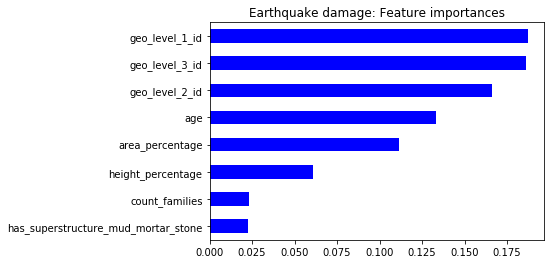

In [50]:
feat_importance = pd.Series(rf.feature_importances_,index=X.columns)
feat_importance.nlargest(8).plot(kind='barh',title='Earthquake damage: Feature importances',colors='b')
plt.gca().invert_yaxis();

#### 8. Evaluation metrics

**8.1 Build several models to compare**

In [51]:
tree = DecisionTreeClassifier()
tree.fit(X_train[:5000], y_train[:5000])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [52]:
rf_small = RandomForestClassifier(n_estimators = 5, max_depth = 5)
rf_small.fit(X_train[:10000],y_train[:10000])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
rf_full = RandomForestClassifier(n_estimators = 35)
rf_full.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators = 35)
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=35,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

**8.2 Confusion matrix**

The predicted classes are represented in the columns of the matrix; the actual classes are in the rows of the matrix. This gives four cases as below.

In [93]:
pd.DataFrame({'Predicted: Class 0':['True Negative','False Negative'],
                        'Predicted: Class 1':['False Negative','False Positive']},
            index = ['Actual: Class 0', 'Actual: Class 1'])

Predicted: Class 0 Predicted: Class 1
Actual: Class 0      True Negative     False Negative
Actual: Class 1     False Negative     False Positive

In [56]:
from sklearn.metrics import confusion_matrix

y_preds = rf_full.predict(X_test)
cm = confusion_matrix(y_test, y_preds)

print(cm)

[[37915  5299]
 [ 8894 13043]]


In [57]:
pd.DataFrame(cm, columns = ['Predicted: Moderate damage', 'Predicted: Severe damage'],
            index = ['Actual: Moderate damage', 'Actual: Severe damage'])

Predicted: Moderate damage  Predicted: Severe damage
Actual: Moderate damage                       37915                      5299
Actual: Severe damage                          8894                     13043

**8.3 Precision, recall and F1 score**

Accuracy answers the question: what proportion of predictions were correct:

$$accuracy = \frac{TP+TN}{TP + TN + FP + FN}$$


Precision: When it predicts the positive result, how often is it correct?

$$precision = \frac{TP}{TP + FP}$$

Recall: Out of the positive examples, what proportion did it guess correctly?

$$recall = \frac{TP}{TP + FN}$$

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     43214
           1       0.71      0.59      0.65     21937

    accuracy                           0.78     65151
   macro avg       0.76      0.74      0.74     65151
weighted avg       0.78      0.78      0.78     65151



#### 8.4 ROC Curve

Note: you can always change your decision threshold when guessing positive.

By default, we class an example as positive when predicted probability (positive) > 50%.
You can adjust the sensitivity to whatever threshold you want.

A 90% probability threshold would get you more false negatives; a 30% threshold would get you a lot of false positives.

Plot this trade-off on the ROC curve. Classifiers that hug the top-left corner are preferable (many true positives, few false positives).

In [59]:
y_pred_prob_tree = tree.predict_proba(X_test)[:,1]
y_pred_prob_rf_small = rf_small.predict_proba(X_test)[:,1]
y_pred_prob_rf_full = rf_full.predict_proba(X_test)[:,1]
y_pred_prob_gb = gb.predict_proba(X_test)[:,1]


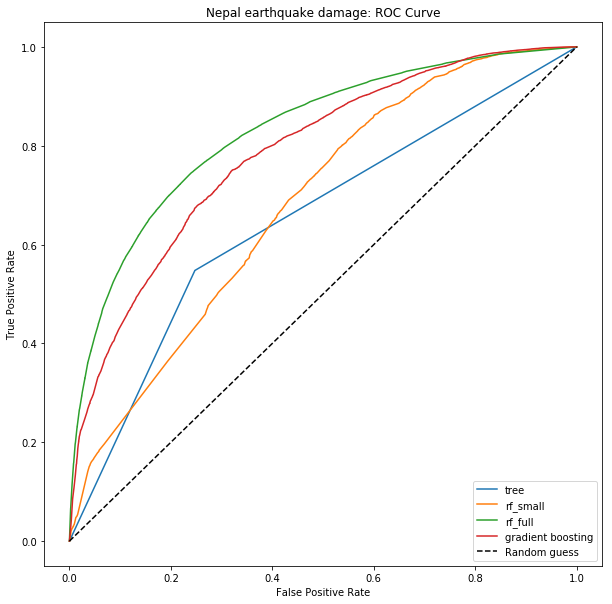

In [60]:
from sklearn.metrics import roc_curve

fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob_tree)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob_rf_small)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_prob_rf_full)
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_prob_gb)

# create plot
f,ax = plt.subplots(figsize = [10,10])
plt.plot(fpr1, tpr1, label='tree')
plt.plot(fpr2, tpr2, label='rf_small')
plt.plot(fpr3, tpr3, label='rf_full')
plt.plot(fpr4, tpr4, label='gradient boosting')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Nepal earthquake damage: ROC Curve')
#plt.xlim([-0.02, 1])
#plt.ylim([0, 1.02])
plt.legend(loc="lower right");